In [1]:
import sys
sys.path.append("..")

from pathlib import Path
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from sklearn.covariance import GraphicalLassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
from nilearn.connectome import GroupSparseCovariance

from bold_dementia.data.memento import Memento
from bold_dementia.data.phenotypes import days_to_onset
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.matrices import plot_matrices

BIDSDIR = Path("/georges/memento/BIDS")
PPATH = Path("/bigdata/jlegrand/data/Memento/output/augmented_phenotypes.csv")
ATLAS = "schaeffer"
SOFT = False
FROM_CACHE = False
confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}

phenotypes = Memento.load_phenotypes(PPATH)


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
no_dementia_mask = phenotypes.days_to_onset.isna()
controls = phenotypes[no_dementia_mask]
AD_mask = ((phenotypes.MA == 1))
demented = phenotypes[AD_mask]
subjects = pd.concat([demented, controls])

In [3]:
from nilearn.interfaces.bids import get_bids_files, parse_bids_filename
fmri_path = get_bids_files(
    BIDSDIR / "derivatives/fmriprep-23.2.0",
    "bold",
    modality_folder="func",
    file_type="nii.gz",
    filters=[
    #    #("space", "MNI152NLin2009cAsym")
        ("space", "MNI152NLin6Asym"),
    ],
)

In [4]:
df = pd.DataFrame(map(parse_bids_filename, fmri_path))

rest_dataset = pd.merge(
    left=df,
    right=subjects,
    how="left",
    on="sub"
)
rest_dataset = rest_dataset.dropna(axis=0, subset="CEN_ANOM")
rest_dataset.sample(n=4)

,file_path,file_basename,file_tag,file_type,file_fields,sub,ses,task,space,res,...,DEMENCE_DAT,APOE_eps4,APOE_geno,APOE_y,M000,M024,M048,declared_dementia,age_of_onset,days_to_onset
640,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0630_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0630,M000,rest,MNI152NLin6Asym,2,...,NaT,0.0,eps3/eps3,Non,2014-09-05,2016-08-04,NaT,False,NaN,NaN
1229,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-1182_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",1182,M000,rest,MNI152NLin6Asym,2,...,NaT,0.0,eps3/eps3,Non,2013-04-15,2015-03-16,2017-04-14,False,NaN,NaN
145,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0142_ses-M024_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0142,M024,rest,MNI152NLin6Asym,2,...,NaT,0.0,eps3/eps3,Non,2012-06-21,2014-09-02,2017-03-16,False,NaN,NaN
421,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0423_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0423,M000,rest,MNI152NLin6Asym,2,...,NaT,0.0,eps3/eps3,Non,2014-04-09,NaT,NaT,False,NaN,NaN


In [5]:

current_scan = rest_dataset.apply(lambda row: row[row.ses], axis=1)

rest_dataset["scan_to_onset"] = days_to_onset(current_scan, rest_dataset["DEMENCE_DAT"])

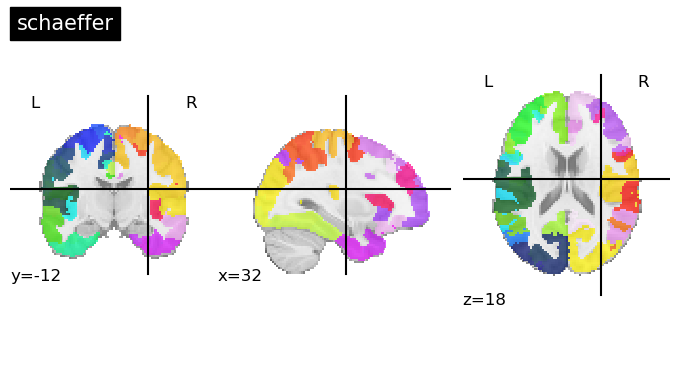

In [6]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
atlas.plot()
plotting.show()

In [7]:

masker = atlas.fit_masker()
control_ts = []
pre_AD_ts = []
AD_ts = []
for index, subrow in rest_dataset.groupby("declared_dementia").sample(n=5, random_state=1234).iterrows():
    # Preloading with nib is faster than passing a string path
    # to nilearn
    if FROM_CACHE:
        raise NotImplementedError()
    else:
        img = nib.load(subrow.file_path)
        confounds, sample_mask = load_confounds(
            subrow.file_path,
            **confounds_strategy
        )
        ts = masker.transform(img, confounds, sample_mask)
    print(subrow.scan_to_onset)
    if subrow.scan_to_onset <= 0:
        AD_ts.append(ts)
    elif math.isnan(subrow.scan_to_onset):
        control_ts.append(ts)
    else:
        pre_AD_ts.append(ts)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The de

nan


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The de

nan


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The de

nan


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The de

nan


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The de

nan


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


372.0


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The de

0.0


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The de

-549.0


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


-360.0


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


-406.0


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


In [14]:
AD_gsc = GroupSparseCovariance()
control_gsc = GroupSparseCovariance()
sc = StandardScaler() # Could be refactored in a more elegant way but whatever
AD_gsc.fit([sc.fit_transform(ts) for ts in AD_ts])
control_gsc.fit([sc.fit_transform(ts) for ts in control_ts])

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/connectome/group_sparse_cov.py:496: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/connectome/group_sparse_cov.py:496: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


GroupSparseCovariance()

In [16]:

# TODO Macro labelling, should be added in atlases?
# TODO all those labels, refactor names
from matplotlib.ticker import FixedLocator

# TODO For clarity : more ticks?
def plot_matrices(cov, prec, title, labels, macro_labels=True):
    """Plot covariance and precision matrices.
    For macro labels only schaeffer has been tested so far
    """
    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # We want network labels to span over several rows
    if macro_labels:
        networks = np.array(list(map(lambda x: str(x).split("_")[2], labels)))
        sort_index = np.argsort(networks)
        ticks = []
        lbls = []
        prev_label = None
        for i, label in enumerate(networks[sort_index]):
            if label != prev_label:
                ticks.append(i)
                lbls.append(label)
                prev_label = label
                ax1.hlines(i, 0, len(labels), colors="black", linestyles="dotted")
                ax2.hlines(i, 0, len(labels), colors="black", linestyles="dotted")
                ax1.vlines(i, 0, len(labels), colors="black", linestyles="dotted")
                ax2.vlines(i, 0, len(labels), colors="black", linestyles="dotted")

        ticks.append(i + 1)
        
    else:
        sort_index = np.arange(len(prec))

    sns.heatmap(cov[np.ix_(sort_index, sort_index)], ax=ax1, vmin=-1, vmax=1, cmap="seismic")
    sns.heatmap(prec[np.ix_(sort_index, sort_index)], ax=ax2, cmap="seismic", vmin=-span, vmax=span)

    # This is a bit unstatisfying
    if macro_labels:
        ax1.yaxis.set_minor_locator(FixedLocator(ticks))
        ax1.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax1.set_yticklabels(lbls, rotation=0)
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    return fig

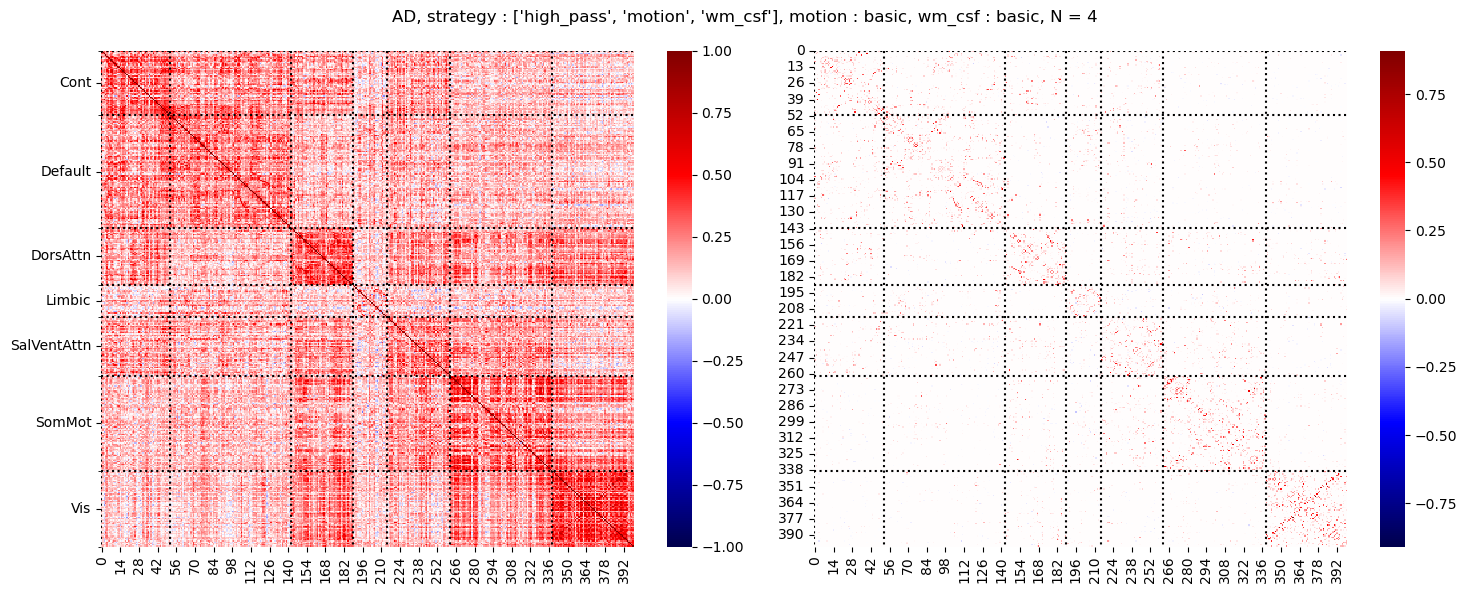

In [20]:
title = ", ".join([f"{k} : {v}" for k, v in confounds_strategy.items()])

# Mean ou pas mean?
plot_matrices(AD_gsc.covariances_.mean(axis=2), -AD_gsc.precisions_.mean(axis=2), f"AD, {title}, N = {len(AD_ts)}", atlas.labels)

plotting.show()

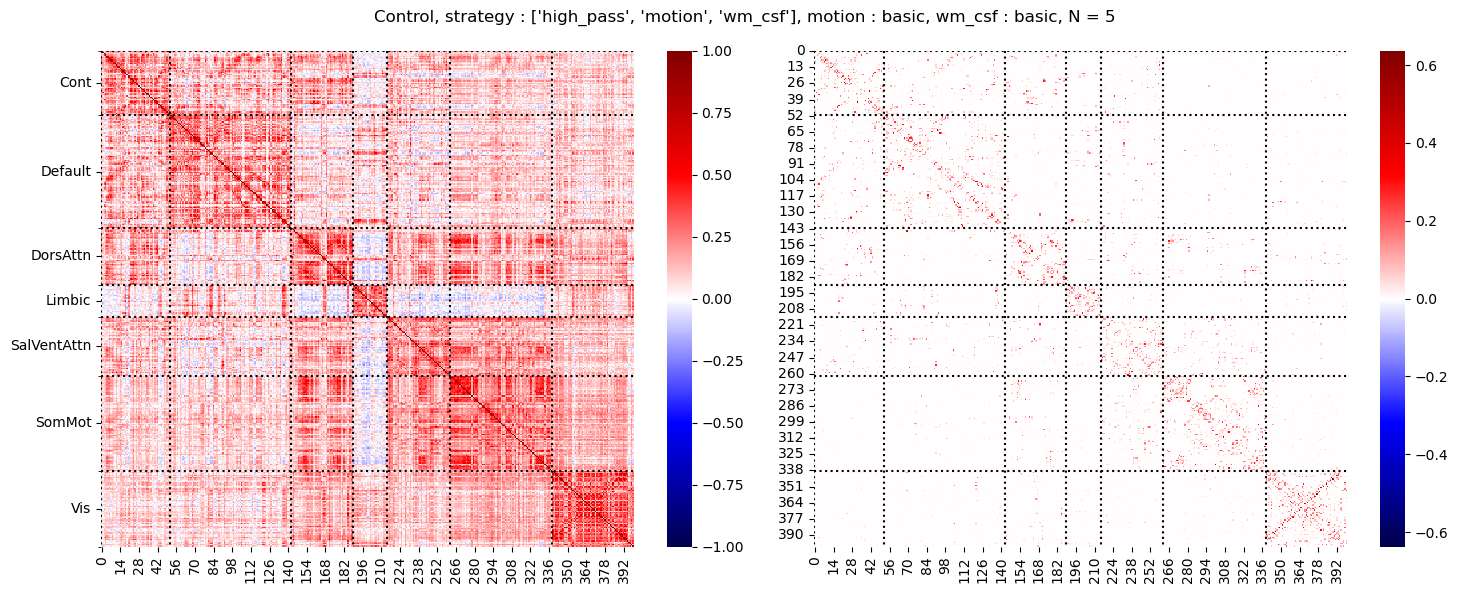

In [22]:

# Mean ou pas mean?
plot_matrices(control_gsc.covariances_.mean(axis=2), -control_gsc.precisions_.mean(axis=2), f"Control, {title}, N = {len(control_ts)}", atlas.labels, macro_labels=True)

plotting.show()

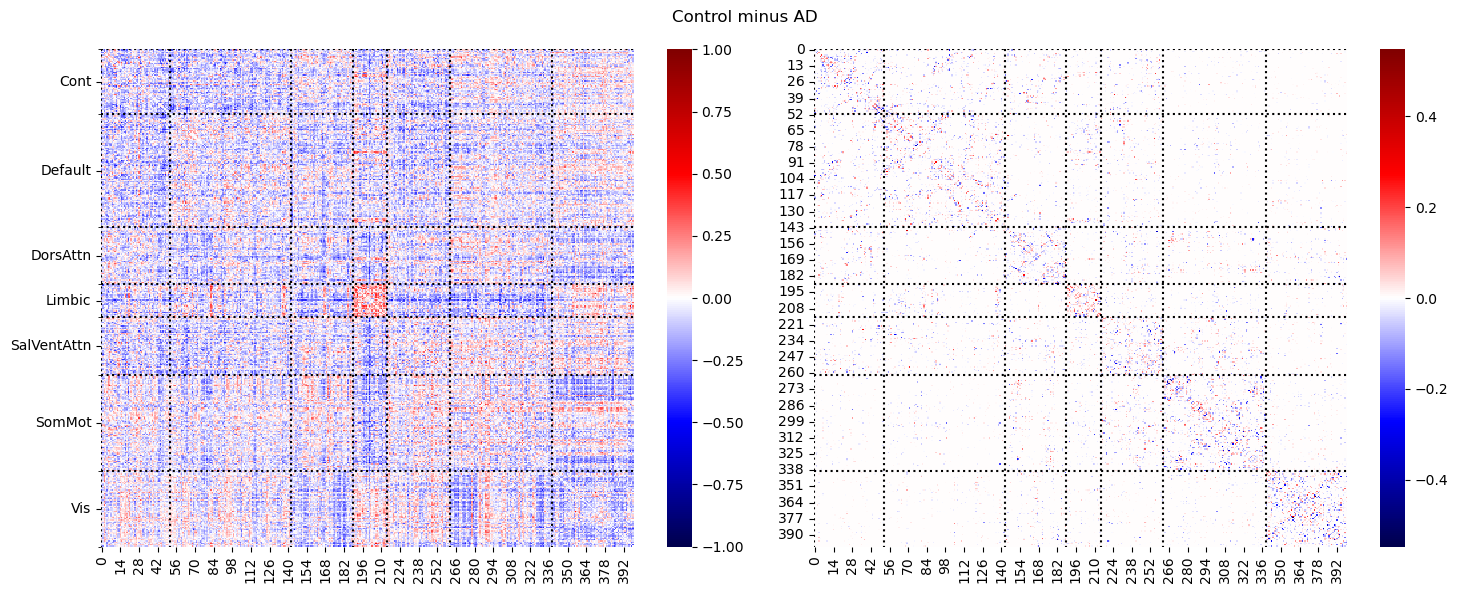

In [23]:

plot_matrices(
    control_gsc.covariances_.mean(axis=2) - AD_gsc.covariances_.mean(axis=2),
    -control_gsc.precisions_.mean(axis=2) + AD_gsc.precisions_.mean(axis=2),
    "Control minus AD",
    atlas.labels
)
plotting.show()